# The MattingMen Proudly Present: Image Matting, Neural and Classical

### Download the Dataset

In [125]:
import gdown
from zipfile import ZipFile
import os
import cv2
import matplotlib.pyplot as plt
from __future__ import division
from numpy.lib.stride_tricks import as_strided
import scipy.sparse
import scipy.sparse.linalg
import pypardiso
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

##🚨🚨🚨 UNCOMMENT TO DOWNLOAD 15gig DATASET 🚨🚨🚨
#Dataset used: https://www.kaggle.com/datasets/laurentmih/aisegmentcom-matting-human-datasets?select=matting
#"30gigs" on kaggle is a lie, dataset is internally duplicated

# def download_and_extract(zip_url, extract_to='./archive/', zip_path='temp.zip'):
#     file_id = zip_url.split('/')[-2]
#     drive_url = f"https://drive.google.com/uc?id={file_id}"
#     gdown.download(drive_url, zip_path, quiet=False)
    
#     with ZipFile(zip_path, 'r') as zip_ref: 
#         zip_ref.extractall(extract_to)
#     os.remove(zip_path)

# google_drive_link = "https://drive.google.com/file/d/1ZWjgJ762I40bYn9DC9IDAsDbvwJ8Dqm5/view?usp=drive_link"
# download_and_extract(google_drive_link)

#### Load Data

In [ ]:
def create_image_dataframe(root_dir):
    data = []
    
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if 'clip_' in subdir:
                image_type = 'clip'
            elif 'matting_' in subdir:
                image_type = 'matting'
            else:
                continue
                
            filename_without_extension = os.path.splitext(file)[0]
            full_path = os.path.join(subdir, file)
            
            data.append([filename_without_extension, full_path, image_type])
    
    df = pd.DataFrame(data, columns=['image_name', 'path', 'type'])
    return df

root_directory = './archive/'
image_df = create_image_dataframe(root_directory)

print(image_df.head())

### Load the Closed Form Matting Implementation 
https://github.com/MarcoForte/closed-form-matting

Full credit to the original paper/ authors. 
We DID go through the effort of understanding their code and loading it accordingly. We also replaced their matrix solver with a multithreaded variant using intel's mkl backend, significantly speeding up the closed form implementation computations. The code below represents strictly the alpha matting implementation and has been carefully severed from the author's other work.

In [ ]:
"""This module implements natural image matting method described in:
    Levin, Anat, Dani Lischinski, and Yair Weiss. "A closed-form solution to natural image matting."
    IEEE Transactions on Pattern Analysis and Machine Intelligence 30.2 (2008): 228-242.

"""

def _rolling_block(A, block=(3, 3)):
    """Applies sliding window to given matrix."""
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = (A.strides[0], A.strides[1]) + A.strides
    return as_strided(A, shape=shape, strides=strides)


def compute_laplacian(img: np.ndarray, mask=None, eps: float =10**(-7), win_rad: int =1):
    """Computes Matting Laplacian for a given image.

    Args:
        img: 3-dim numpy matrix with input image
        mask: mask of pixels for which Laplacian will be computed.
            If not set Laplacian will be computed for all pixels.
        eps: regularization parameter controlling alpha smoothness
            from Eq. 12 of the original paper. Defaults to 1e-7.
        win_rad: radius of window used to build Matting Laplacian (i.e.
            radius of omega_k in Eq. 12).
    Returns: sparse matrix holding Matting Laplacian.
    """

    win_size = (win_rad * 2 + 1) ** 2
    h, w, d = img.shape
    # Number of window centre indices in h, w axes
    c_h, c_w = h - 2 * win_rad, w - 2 * win_rad
    win_diam = win_rad * 2 + 1

    indsM = np.arange(h * w).reshape((h, w))
    ravelImg = img.reshape(h * w, d)
    win_inds = _rolling_block(indsM, block=(win_diam, win_diam))

    win_inds = win_inds.reshape(c_h, c_w, win_size)
    if mask is not None:
        mask = cv2.dilate(
            mask.astype(np.uint8),
            np.ones((win_diam, win_diam), np.uint8)
        ).astype(bool)
        win_mask = np.sum(mask.ravel()[win_inds], axis=2)
        win_inds = win_inds[win_mask > 0, :]
    else:
        win_inds = win_inds.reshape(-1, win_size)

    
    winI = ravelImg[win_inds]

    win_mu = np.mean(winI, axis=1, keepdims=True)
    win_var = np.einsum('...ji,...jk ->...ik', winI, winI) / win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)

    A = win_var + (eps/win_size)*np.eye(3)
    B = (winI - win_mu).transpose(0, 2, 1)
    X = np.linalg.solve(A, B).transpose(0, 2, 1)
    vals = np.eye(win_size) - (1.0/win_size)*(1 + X @ B)

    nz_indsCol = np.tile(win_inds, win_size).ravel()
    nz_indsRow = np.repeat(win_inds, win_size).ravel()
    nz_indsVal = vals.ravel()

    # rewrite L in CSR format
    L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))
    return L


def closed_form_matting_with_prior(image, prior, prior_confidence, consts_map=None):
    """Applies closed form matting with prior alpha map to image.

    Args:
        image: 3-dim numpy matrix with input image.
        prior: matrix of same width and height as input image holding apriori alpha map.
        prior_confidence: matrix of the same shape as prior hodling confidence of prior alpha.
        consts_map: binary mask of pixels that aren't expected to change due to high
            prior confidence.

    Returns: 2-dim matrix holding computed alpha map.
    """

    assert image.shape[:2] == prior.shape, ('prior must be 2D matrix with height and width equal '
                                            'to image.')
    assert image.shape[:2] == prior_confidence.shape, ('prior_confidence must be 2D matrix with '
                                                       'height and width equal to image.')
    assert (consts_map is None) or image.shape[:2] == consts_map.shape, (
        'consts_map must be 2D matrix with height and width equal to image.')

    print('Computing Matting Laplacian.')
    laplacian = compute_laplacian(image, ~consts_map if consts_map is not None else None)
    confidence = scipy.sparse.diags(prior_confidence.ravel())
    print('Solving for alpha.')
    solution = pypardiso.spsolve(
        laplacian + confidence,
        prior.ravel() * prior_confidence.ravel()
    )
    alpha = np.minimum(np.maximum(solution.reshape(prior.shape), 0), 1)
    return alpha


def closed_form_matting_with_scribbles(image, scribbles, scribbles_confidence=100.0):
    """Apply Closed-Form matting to given image using scribbles image."""

    assert image.shape[:2] == scribbles.shape, 'scribbles must have exactly same shape as image.'
    consts_map = scribbles != 0.5
    return closed_form_matting_with_prior(
        image,
        scribbles,
        scribbles_confidence * consts_map,
        consts_map
    )


In [127]:
def load_img(df, idx, normalize_to_float=False):
    matting_row = df[df['type'] == 'matting'].iloc[idx]
    clip_row = df[df['type'] == 'clip'].iloc[idx]
    matting_img = cv2.imread(matting_row['path'], cv2.IMREAD_UNCHANGED)[:,:,3]
    clip_img = cv2.imread(str(clip_row['path']))
    clip_img = cv2.cvtColor(clip_img, cv2.COLOR_BGR2RGB)

    if(normalize_to_float):
        clip_img = clip_img / 255.0
        matting_img = matting_img / 255.0
    return matting_img.astype(np.float32), clip_img.astype(np.float32)

array([[ 36.69729 ,  32.22751 ,  29.111502],
       [223.3373  , 166.53677 , 141.44498 ],
       [178.6071  , 112.41153 ,  90.91081 ]], dtype=float32)

array([[236.29922, 237.32545, 237.55693],
       [212.63055, 102.77841, 105.87036],
       [222.12682, 216.98587, 218.26517]], dtype=float32)

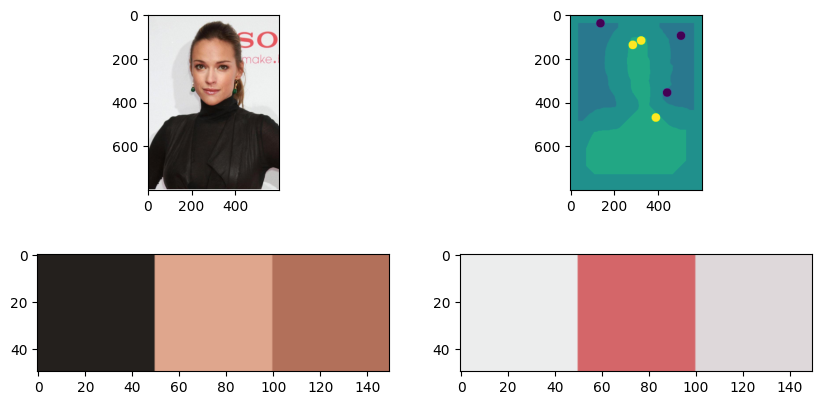

array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]])

In [198]:
#The below squiggle generator performs image erosion so as to deterministically place "squiggles" at points resembling the centers of the foreground / background regions, as a human might.
def get_squiggles(image, colorimage, threshold=4, area=0.1, clusters=6, erosion_conf=0.5, plot=False):
    kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ], dtype=np.uint8)
    
    #set up the foreground and background squiggles
    target_alpha = image.copy()
    background_alpha = 255-image.copy()
    
    #get mask ratios set up
    mask1_initial_total = np.sum(image)
    mask2_initial_total = np.sum(255-image)
    mask1_area = mask1_initial_total
    mask2_area = mask2_initial_total

    #erode both until they're 10% of the original area (proudly our own idea :D)
    while(mask1_area / mask1_initial_total > area):
        neighbor_count = cv2.filter2D((target_alpha > 0).astype(np.uint8), -1, kernel, borderType=cv2.BORDER_CONSTANT)
        target_alpha[(neighbor_count < threshold) & (target_alpha > 0)] = 0
        mask1_area = np.sum(target_alpha)

    while(mask2_area / mask2_initial_total > area):
        neighbor_count = cv2.filter2D((background_alpha >0).astype(np.uint8), -1, kernel, borderType=cv2.BORDER_CONSTANT)
        background_alpha[(neighbor_count < threshold) & (background_alpha > 0)] = 0
        mask2_area = np.sum(background_alpha)

    #some arbitrary blurring to help tackle regions that shrank akwardly / too uniformly
    target_alpha=cv2.blur(target_alpha, (20,20)) > 1 
    background_alpha=cv2.blur(background_alpha,(20,20)) > 1


    #at this point, we explored several alternative ideas, that each usually began with k-means
    #as it turns out, our closed form solution is hoping that we not only place scribbles appropriately on the foreground and background
    #but that we also capture some of the colors in our squiggle region that most closely represent this foreground or background color composition

    #unfortunately, our squiggle erosion algorithm is naive to color. The thought was then: 
    #the "select top N" colors idea was our own, though googling helped us decide between clustering options. "Eigencolors" lead to an interesting side quest learning about eigengrau
    
    # 1.) let's select some colors using K means from within the squiggle region
    # 2.) let's find the closest pixels to these colors in the squiggle region
    # 3.) let's drop circle squiggles on these points and use that instead.
    
    pixels = colorimage.reshape(-1, 3)
    foreground_mask = target_alpha.flatten()
    background_mask = background_alpha.flatten()

    foreground_pixels = pixels[foreground_mask]
    background_pixels = pixels[background_mask]
    
    clf = KMeans(n_clusters=clusters)
    foreground_labels = clf.fit_predict(foreground_pixels)
    foreground_palette = clf.cluster_centers_
    display(foreground_palette)

    clf2 = KMeans(n_clusters=clusters)
    background_labels = clf2.fit_predict(background_pixels)
    background_palette = clf2.cluster_centers_
    display(background_palette)
    
    canvas = np.ones_like(image) / 2
    canvas = canvas + erosion_conf*(target_alpha/2) - erosion_conf*(background_alpha/2)
    #nearest neighbors pixelwise by euclidean color dist
    for color in foreground_palette:
        mask_indices = np.argwhere(target_alpha)
        color_pixels_in_mask = colorimage[target_alpha]
        distances = np.linalg.norm(color_pixels_in_mask - color, axis=1)
        closest_index = np.argmin(distances)
        closest_point = mask_indices[closest_index]
        cv2.circle(canvas, (closest_point[1], closest_point[0]), 20, (1), -1)

    for color in background_palette:
        mask_indices = np.argwhere(background_alpha)
        color_pixels_in_mask = colorimage[background_alpha]
        distances = np.linalg.norm(color_pixels_in_mask - color, axis=1)
        closest_index = np.argmin(distances)
        closest_point = mask_indices[closest_index]
        cv2.circle(canvas, (closest_point[1], closest_point[0]), 20, (0), -1)


    #lets also show the palette, just to make sure we're making smart choices...
    if(plot):
        fgp = np.zeros((50, 50 * clusters, 3), dtype=np.uint8)
        for i in range(clusters):
            fgp[:, i*50:(50*i+50), :] = foreground_palette[i]

        bgp = np.zeros((50, 50 * clusters, 3), dtype=np.uint8)
        for i in range(clusters):
            bgp[:, i*50:(50*i+50), :] = background_palette[i]

        _, axs = plt.subplots(2,2, figsize=(10, 5))
        matte, clip = load_img(image_df, 15)
        axs[0, 0].imshow(colorimage/255)
        axs[0, 1].imshow(canvas)
        axs[1, 0].imshow(fgp)
        axs[1, 1].imshow(bgp)
        plt.show()
    return canvas


get_squiggles(matte, clip, 4, .4, 3, 0.2, True)




In [204]:
def sigmoid_normalization(image):
    normalized_image = 1 / (1 + np.exp(-image))
    return normalized_image

In [207]:
def display_image_pairs(df, num_images, model):
    fontsize = 10
    
    matting_images = df[df['type'] == 'matting']
    clip_images = df[df['type'] == 'clip']
    
    selected_matting = matting_images.sample(n=num_images)
    
    _, axs = plt.subplots(5, num_images, figsize=(40, 15))

    MSEtotal_CF = 0
    PSNRtotal_CF = 0
    SADtotal_CF = 0

    MSEtotal_UNET = 0
    PSNRtotal_UNET = 0
    SADtotal_UNET = 0
    
    for i, (_, row) in enumerate(selected_matting.iterrows()):
        matting_img = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
        imgname = row['image_name'].split("-")[1]
        clip_row = clip_images[clip_images['image_name'] == row['image_name']].iloc[0]
        clip_img = cv2.imread(str(clip_row['path']))
        clip_img = cv2.cvtColor(clip_img, cv2.COLOR_BGR2RGB)
        matting_img = matting_img[:,:,3]
        scribbles = get_squiggles(matting_img, clip_img, threshold=4, area=0.2, clusters=3, erosion_conf=0, plot=False)
        matting_img = matting_img/255
        #show ground truth
        axs[0, i].imshow(matting_img, cmap='gray')
        axs[0, i].set_title(f"Matting: {imgname}", size=fontsize)
        axs[0, i].axis('off')
        
        #show color
        axs[1, i].imshow(clip_img)
        axs[1, i].set_title(f"Clip: {imgname}", size=fontsize)
        axs[1, i].axis('off')

        #Show scribbles
        axs[2, i].imshow(scribbles)
        axs[2, i].set_title(f"Squiggles: {imgname}", size=fontsize)
        axs[2, i].axis('off')

        #Show alpha
        scaled_image = cv2.resize(clip_img, (512, 512))/255
        scribbles_resized = cv2.resize(scribbles, (512,512))
        alpha = closed_form_matting_with_scribbles(scaled_image, scribbles_resized)
        alpha = cv2.resize(alpha, (600,800))
        axs[3, i].imshow(alpha, cmap='gray')
        axs[3, i].set_title(f"C.F. Matte: {imgname}", size=fontsize)
        axs[3, i].axis('off')

        #show model output
        with torch.no_grad():
            model.eval()
            model_input = transform((scaled_image).astype(np.float32)).unsqueeze(0)
            model_input = model_input.to('cuda')
            print(model_input.shape)
            out = np.array(np.transpose(model(model_input)[0].cpu(),(1,2,0)))
        out = cv2.resize(out, (600,800))
        axs[4, i].imshow(out, cmap='gray')
        axs[4, i].set_title(f"Unet Matte: {imgname}", size=fontsize)
        axs[4, i].axis('off')
        
        out = sigmoid_normalization(out)

        MSE = np.mean((alpha - matting_img) ** 2)
        MSEtotal_CF += MSE
        PSNRtotal_CF += 20 * np.log10(1 / np.sqrt(MSE))
        SADtotal_CF += np.sum(np.abs(alpha - matting_img))

        MSE = np.mean((out - matting_img) ** 2)
        MSEtotal_UNET += np.mean((out - matting_img) ** 2)
        PSNRtotal_UNET += 20 * np.log10(1 / np.sqrt(MSE))
        SADtotal_UNET += np.sum(np.abs(out - matting_img))
        
    SADtotal_CF /= num_images
    MSEtotal_CF /= num_images
    PSNRtotal_CF /= num_images

    SADtotal_UNET /= num_images
    PSNRtotal_UNET /= num_images
    MSEtotal_UNET /= num_images
   

    print(f"Average Closed Form SAD: {SADtotal_CF:.2f}")
    print(f"Average Closed Form MSE: {MSEtotal_CF:.5f}")
    print(f"Average Closed Form PSNR: {PSNRtotal_CF:.2f} dB")

    print(f"Average UNET SAD: {SADtotal_UNET:.2f}")
    print(f"Average UNET MSE: {MSEtotal_UNET:.5f}")
    print(f"Average UNET PSNR: {PSNRtotal_UNET:.2f} dB")

    plt.show()


model = torch.load("./best_model.pt")
display_image_pairs(image_df, 2, model)


array([[ 26.00721366,  22.72951427,  22.10931603],
       [245.59892183, 205.56945193, 178.42587601],
       [155.99606742,  97.8088015 ,  70.41966292]])

array([[  1.33642488,   1.32200853,   1.21406489],
       [138.16470588, 127.72941176, 122.87058824],
       [ 57.18905473,  53.10447761,  50.51243781]])

Computing Matting Laplacian.


## U-Net Time!
Below we train a U-Net on a fraction of the dataset.

In [18]:
from pandas import DataFrame
from torch.nn import Module, Conv2d, MaxPool2d, ReLU, BCEWithLogitsLoss, ConvTranspose2d, BatchNorm2d
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

# Credit to https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201

class conv_block(Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = BatchNorm2d(out_c)
        self.conv2 = Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = BatchNorm2d(out_c)
        self.relu = ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

#Set up the unet
#Originally attempted hand implementation but faced substantial challenges. 
#Credit again to medium article linked above for this one
class Unet(Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        self.b = conv_block(512, 1024)

        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        self.outputs = Conv2d(64, 1, kernel_size=1, padding=0)
        
    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs
        
transform = transforms.Compose([transforms.ToTensor()]) #better practice might be to integrate resizing here
class ImageDataset(Dataset):
    def __init__(self, df: DataFrame, n=20):
        self.images = df[df['type'] == 'matting']['image_name']
        self.images = self.images.sample(n, random_state=123)
        self.df = df[df['image_name'].isin(self.images)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        matting, color = load_img(self.df, idx, True)
        
        matting = cv2.resize(matting, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        color = cv2.resize(color, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

        color = transform(color)
        matting = transform(matting)
        return color, matting
    
class TestImageDataset(Dataset):
    def __init__(self, df: DataFrame, n=20):
        self.images = df[df['type'] == 'matting']['image_name']
        self.images = self.images.sample(n, random_state=321)
        self.df = df[df['image_name'].isin(self.images)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        matting, color = load_img(self.df, idx, True)
        
        matting = cv2.resize(matting, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        color = cv2.resize(color, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

        color = transform(color)
        matting = transform(matting)
        return color, matting

In [36]:
train_dataset = ImageDataset(image_df, n=500)
test_dataset = TestImageDataset(image_df, n=60)
train_steps=500//4
test_steps = 15
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
model = Unet().to('cuda')
loss = BCEWithLogitsLoss()
opt = Adam(model.parameters(), lr=0.001)
epochs = 50
torch.device('cuda')
bestTestLoss = 2

lossesOverTime = [[]]

for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    model.train()
    for images, masks in train_loader:
        (images,masks) = (images.to('cuda'), masks.to('cuda'))
        y_pred = model(images)
        current_loss = loss(y_pred, masks)
        opt.zero_grad()
        current_loss.backward()
        opt.step()
        train_loss+=current_loss.item()
    
    with torch.no_grad():
        model.eval()
        for images, masks in test_loader:
            (images,masks) = (images.to('cuda'), masks.to('cuda'))
            y_pred = model(images)
            current_loss = loss(y_pred, masks)
            test_loss+=current_loss.item()

    train_loss = train_loss / train_steps
    test_loss = test_loss / test_steps
    lossesOverTime.append([train_loss, test_loss])
    if(test_loss < bestTestLoss):
        bestTestLoss = test_loss
        torch.save(model, "best_model.pt")

    print("Epoch" + str(epoch) + " Train Loss: " + str(train_loss) + " Test Loss: " + str(test_loss))
        

Epoch0 Train Loss: 0.589528754234314 Test Loss: 0.8159571627775828
Epoch1 Train Loss: 0.5128450975418091 Test Loss: 0.4531466841697693
Epoch2 Train Loss: 0.443076553106308 Test Loss: 0.45786391496658324
Epoch3 Train Loss: 0.4234321517944336 Test Loss: 0.4112814704577128
Epoch4 Train Loss: 0.40623291659355165 Test Loss: 0.4299197256565094
Epoch5 Train Loss: 0.3801400821208954 Test Loss: 0.3878709703683853
Epoch6 Train Loss: 0.37262420427799225 Test Loss: 0.3364482243855794
Epoch7 Train Loss: 0.3482739003896713 Test Loss: 0.3153642912705739
Epoch8 Train Loss: 0.3274239305257797 Test Loss: 0.31631338198979697
Epoch9 Train Loss: 0.3110790729522705 Test Loss: 0.3237533926963806
Epoch10 Train Loss: 0.29819971418380736 Test Loss: 0.27348031202952067
Epoch11 Train Loss: 0.28851374340057373 Test Loss: 0.3141932666301727
Epoch12 Train Loss: 0.2716829208135605 Test Loss: 0.33446110288302106
Epoch13 Train Loss: 0.2576158444881439 Test Loss: 0.25431721011797587
Epoch14 Train Loss: 0.247241089701652

KeyboardInterrupt: 

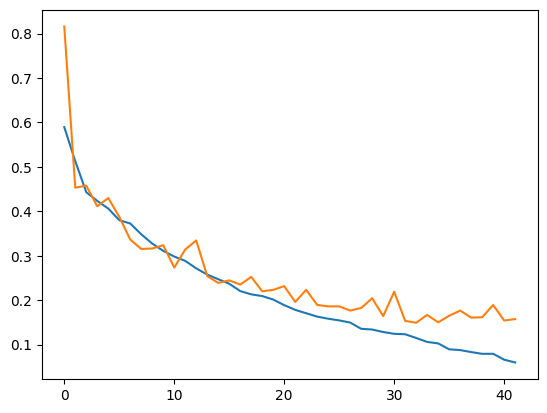

In [37]:
lossOverTimneToEnd = lossesOverTime[1:]
print()
plt.plot(lossOverTimneToEnd)